<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph). The concept of a directed graph is important since it gives us an indication that our dataset represents a social media system such as Instagram or Twitter with the concept of "Follower-Followee", unlike a social media system such as Linkedin or Facebook, where the relationship is simply Connection/Friend Based.

### Data Overview
Taken data from facebook's recruting challenge on Kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination each edge in graph. 
 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  
 
 Total Number of Vertices/Nodes/Users that we have in our dataset = 18,62,220 (1.86 Million approx)
 Total Number of Directed Edges that we have in our dataset       = 94,37,520 (9.43 Million approx)
 
 <h4> Note </h4> 
 
 * All the information that we have been provided over here are vertex pairs with connecting edges.
 * There is no metainformation available to us over here. However in the real world if we were engineers at Instagram/Facebook we would have far more data to work with. Eg :- We would have information about the cities in which users U(i) and U(j) live, the schools and colleges to which U(i) and U(j) went etc. All the information that we have in this scenario is whether the persons are following each other or not.
 * Note that here we have just been provided with one snapshot of the data (edge information) at a time = t. However in the real world if we were engineers at Facebook/Instagram we would have this link information at various time because as the network grows, people are following new friends. -> This network is actually very dynamic in the real world.
    
<h4> Some Terminologies </h4>

* An entire system/network of connections in Applied Mathematics or Computer Science is called a graph. In our scenario the individual people are represented by nodes/vertices whereas these Social Network users are connected with the help of edges.
* A graph is represented by a set of vertices/nodes where each vertex/node corresponds to a user. Edges/Links can be thought of as representing friendships/connections (in social networks like Facebook or Linkedin) or "Follower-Followee" Relationship (in social networks like Twitter/Instagram where people follow each other).
* A Graph in a nutshell is a set of vertices and a set of edges. Mathematically a graph is written as follows :-
            G = <V,E> , where E refers to an Edge -> pair of 2 vertices.
            E = [U(i),U(j)]    
* Wherever there is a direction to the edge they are called directed edges whereas the edges in the previous Linkedin/Facebook scenario are called undirected edges. In the case of directed edges it is possible that there are 2 edges between 2 vertices : one edge in each direction.
* The graph with directed edges is called a directed graph and the graph with undirected edges is called an undirected graph. The dataset that we have for this problem is a directed graph. 
* A path in a graph is basically a valid sequence of edges that you can follow. 

### Mapping the Problem into Supervised Learning Problem:
- What we do to map the problem to a supervised learning problem is that the presence of a directed edge between 2 vertices is represented as class 1 whereas the absence of a directed edge is represented as class 0. Now since we have 2 classes, this becomes a Binary Classification Task.
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg
    
<h4> Q. How do you featurize this data? </h4>

* We can featurize our data with the help of Graph theoretic or Graph based features. One common sensical feature that we can employ is the number of common vertices. If there are a lot of common vertices there is a very high chance that the 2 users have similar interests. (Because of a lot of overlap between the 2 sets)
* Hence, in such a scenario the first user would be interested in following the non-common vertices present in the set of second user and vice-versa. Similarly there is a high chance that these 2 users would be interested in following each other.
* Similarly if User-1 is following User-2 there is a very high probability that User-2 also follows User-1. This is called the 'Following Back' Feature -> This is a Binary Feature.

### Business objectives and constraints:  
- No Low-Latency Requirement :- The way that most of the social networks compute and determine whether there should be an edge between 2 users is that these predictions are updated on a regular basis - This regularity could be daily or any other duration. For a user you compute which all users he/she should follow in this interval, and you return the Top 5 or Top 10 users that he/she should be following. Basically this computation need not be carried out after the user logs in, but can be precomputed and stored in a hash table like data structure and brought up to notice whenever the user logs in.
- Probability of prediction is useful to recommend the Highest probability links :- They are useful because they help us rank the users who have the highest probability of being followed by the user.

### Performance metric for Supervised Learning:  
- We got to suggest connections which are most likely to be correct and we should try and not miss out on any connections :- This basically means that both Precision as well as Recall are important for which we need high values. So F1-score is a good choice.
- Another good metric could be 'Precision at Top K' ie K over here could be any integer. Let K=10. So 'Precision at Top 10' says that for a user if you have 10 vertices (ie. Top 10 users that our user should be following), how many of them are actually correct. This metric is useful because for most social networks you do not get to show all the users whom the user should be following - You only have a limited space available to display these. It is a measure that if you are recommending 10 users, how many of them are eventually followed by our user -> But here we will only look at optimizing F1-Score.
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd #pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np  #Do aritmetic operations on arrays

import matplotlib # matplotlib: used to plot graphs
import matplotlib.pylab as plt
import seaborn as sns #Plots
import math
import pickle
import os
import xgboost as xgb
import gc
import networkx as nx #for studying graphs and networks
import pdb
  

from tqdm import tqdm
from matplotlib import rcParams #Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('facebook_train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False) #obtaining file without header
    print("saved the graph into file")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    #DiGraph()  over here basically means that we are creating a directed graph.
    
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


<h4> Observations </h4>

* In-degree refers to the number of edges/links that are coming into a vertex whereas out-degree refers to the number of edges/links that are going out from a vertex. Thus the average in-degree and average out-degree values are measured across all the vertices. 
* For us the average in-degree and average out-degree values tell us that on an average there are 5 edges originating from each vertex and 5 edges that are coming into a vertex. 

> Displaying a sub graph :

 A Subgraph is basically a subset of vertices and the edges that are present between those vertices.

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


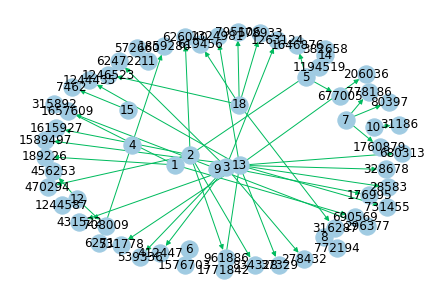

In [3]:
#Displaying a sub graph
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/facebook_train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#read_edgelist() takes the file names without the headers
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf") #plt refers to matplotlib
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [4]:
g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

#The number of nodes could be simply obtained as g.nodes() because g refers to networkx graph or object

The number of unique persons 1862220


## 1.1 No of followers for each person

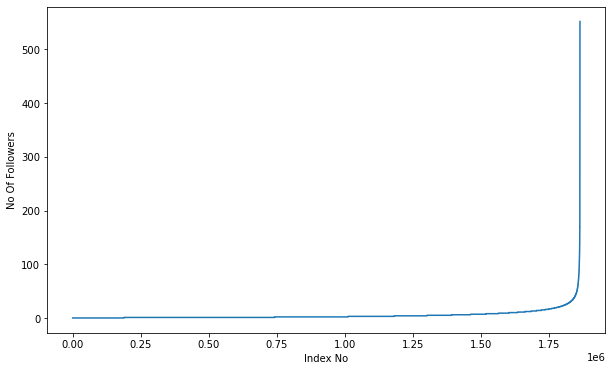

In [5]:
indegree_dist = list(dict(g.in_degree()).values()) 
#returns in-degree for each vertex -> converted into a dictionary and then the values are obtained. Then converted
#to a list : You get a list of all the in-degrees for all the vertices.

indegree_dist.sort()     #sorting the in-degrees
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

<h4> Observations </h4>

* We can easily say that the number of followers for a particular user is the same as the in-degree. Eg:- If my in-degree is 3, it means that 3 other users are following me.
* There is one user with 0 followers.
* There are some users in the middle index values who have more than 0 followers.
* At the end we notice a sharp increase in the follower count ie. there is some user who has greater than 500 followers in the dataset given to us. 
* However, the fact that this rise in the number of followers is very steep means the following :- 
a) Most of our users have very few followers (<40) and there is a very small user subset who have >40 followers.
b) There is atleast one user in our dataset with >500 followers.

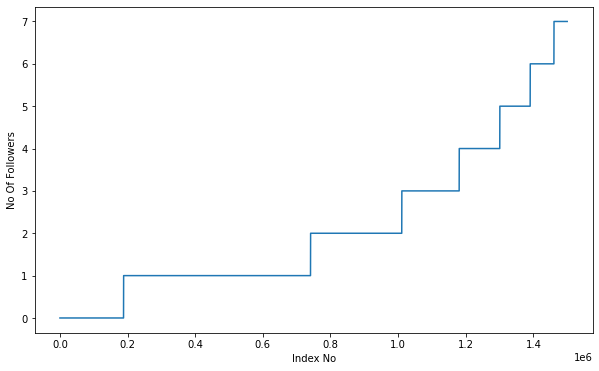

In [6]:
#Because there is a massive scale difference over here, we zoom into this graph.

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000]) #zoomed into users till 1.5 Million.
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

<h4> Observations </h4>

* There are approximately 200K users with 0 followers.
* There are approximately 550K users with 1 follower. (750K - 200K)
* There are approximately 250K users with 2 followers, and so on.
* Even this curve that we obtained is fairly steep once it is smoothened. But we get an idea that approx. 1.5 Million of our users have less than or equal to 7 followers.

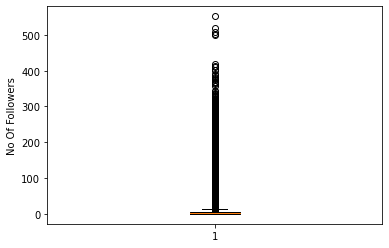

In [7]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

<h4> Observations </h4>

* It is very difficult to read the boxplot that we have obtained over here :- Our 0th, 25th, 50th as well as 75th percentile values, all of them are fairly small.
* There are very few outliers present over here ie. very few users have many followers. Most of the users do not have any followers.

In [8]:
#Having a look at the number of followers from the 90th to the 100th percentile.
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


<h4> Observations </h4>

* 90% of our users have less than 12 followers.
* 99% of our users have their follower count less than or equal to 40.
* There is one user with 552 followers.

In [9]:
# Zooming in further from 99th percentile -100th percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


<h4> Observations </h4>

* 99.9% of users in our social network have 112 or fewer followers.
* This means that there are only 0.1% of users who have more than 112 followers.

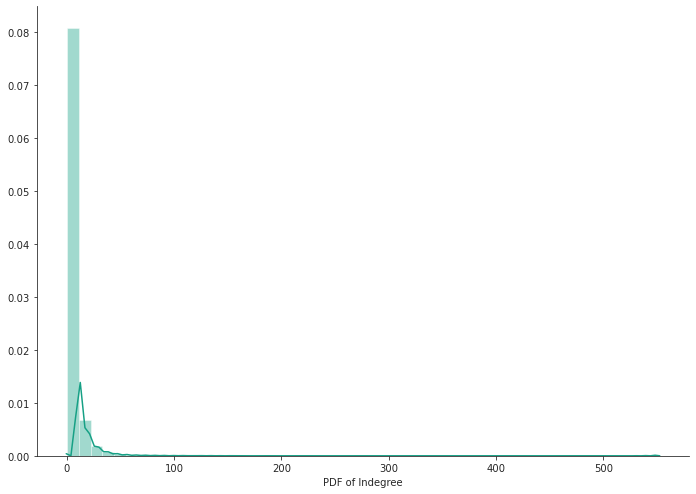

In [10]:
#Plotting the PDF of in-degree

%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

#Green Bar obtained over here refers to the histogram whereas the curve obtained is the smoothed out PDF.

<h4> Observations </h4>

* Most users have a very small number of followers.

## 1.2 No of people each person is following

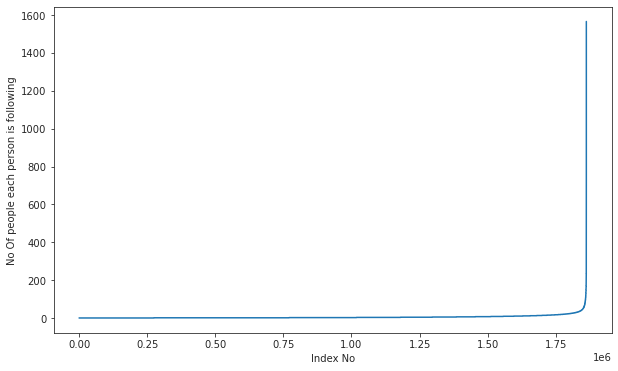

In [11]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort() #sorting the out-degrees

plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

<h4> Observations </h4>

* We can easily say that the number of people that a particular user is following is the same as out-degree. Eg:- If my out-degree is 3, it means that I am following 3 other users.
* Most people are following very few number of people. 
* The maximum number of people that a particular user is following is not more than 1600.

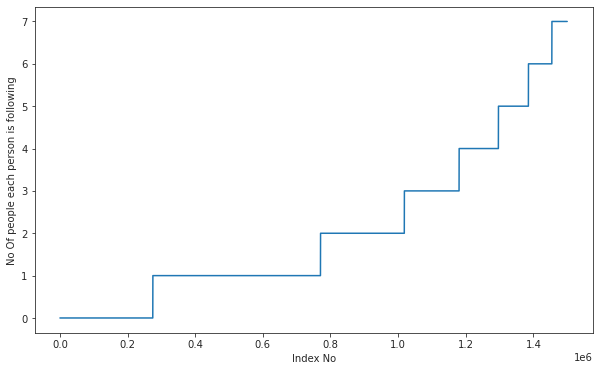

In [12]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()

plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

<h4> Observations </h4>

* There are approximately 250K users who are not following any user.
* There are approximately 540K users who are following only 1 user. (790K - 250K)
* There are approximately 220K users who are following 2 users, and so on.
* Even this curve that we obtained is fairly steep once it is smoothened. But we get an idea that approx. 1.5 Million of our users follow less than or equal to 7 users.

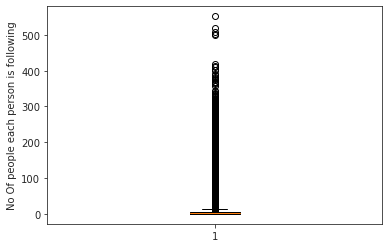

In [13]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

<h4> Observations </h4>

* It is very difficult to read the boxplot that we have obtained over here :- Our 0th, 25th, 50th as well as 75th percentile values, all of them are fairly small.

In [14]:
#Having a look at the number of people being followed from the 90th to the 100th percentile.

for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


<h4> Observations </h4>

* 90% of users in this social network are following less than 12 users.
* 99% of users in this social network have their follower count less than or equal to 40.

In [15]:
#Having a look at the number of people being followed from 99th to the 100th percentile.

for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


<h4> Observations </h4>

* 99.9% of users in this social network are following less than 123 users.
* However there is one person who is following 1566 people.

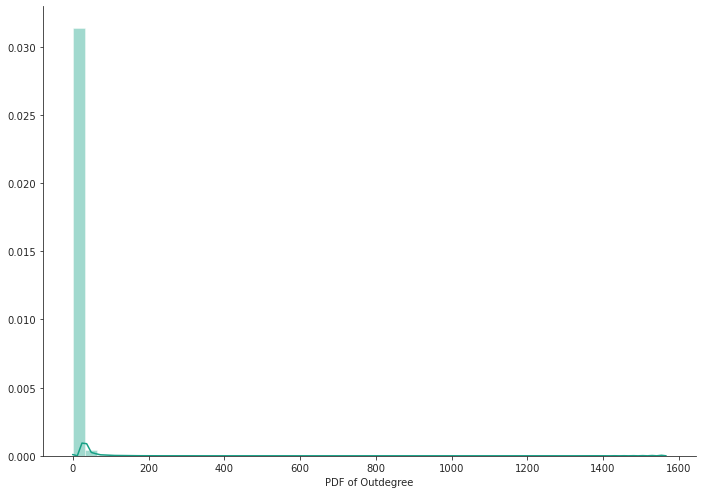

In [16]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

<h4> Observations </h4>

* Exactly like in the previous case, the Histogram or PDF looks very skewed.

In [17]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [18]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [19]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 Both Followers + Following 

<h4> Degree </h4>

* A particular user will have both edges that are coming in (in-degree) as well as the edges that are going out (out-degree).
* If you count all of these edges (that are going out as well as coming in) equally, we obtain the degree. 
        ie. Degree (vertex) = In-degree(vertex) + Out-degree(vertex)
     for a graph G, where G is a Directed Graph.

In [20]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out) #summing up both in-degree and out-degree
in_out_degree = np.array(list(d.values()))

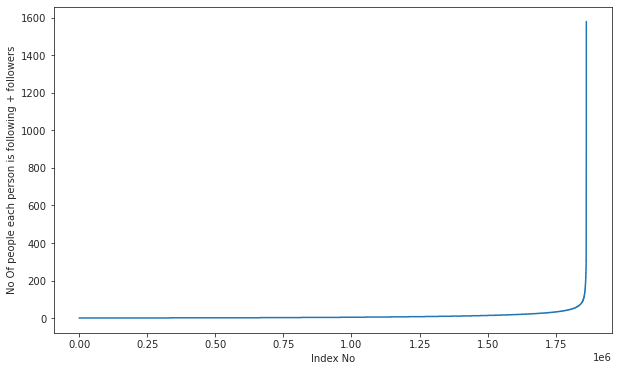

In [21]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

<h4> Observations </h4>

* Again we can see extreme skews, the same way that we found in the case of in-degree and out-degree. We can notice from this graph that most of the people have a degree less than 200.
* The highest value of degree over here for a particular use is approximately 1600.

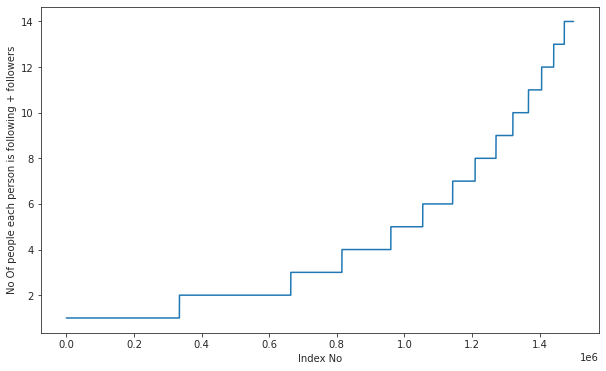

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

<h4> Observations </h4>

* There are approximately 280K users whose sum of (Followers + Following) is 1. 
* There are approximately 320K users whose sum of (Followers + Following) is 2.
* Even this curve that we obtained is fairly steep once it is smoothened. We get an idea that approx. 1.5 Million of our users have their degree less than 14.

In [23]:
#Having a look at (Number of Followers + Number of Followees) from 90th to the 100th percentile.

for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


<h4> Observations </h4>

* 90% of users in this social network are having a degree less than or equal to 24.
* 99% of users in this social network are having a degree less than or equal to 79.

In [24]:
#Having a look at (Number of Followers + Number of Followees) from 90th to the 100th percentile.

for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


<h4> Observations </h4>

* 99.9% of users in this social network are having a degree less than 221.
* However there is one person in this social network who is having a degree of 1579.

In [25]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [26]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [27]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [28]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


# 2. Posing a problem as a Classification Problem 

* We basically represent '1' as having an edge between 2 vertices and '0' as not having an edge between 2 vertices.
* In the Classification Task that we carry out, some datapoints in the Training Data have to be class 0 and some datapoints have to belong to class 1.
* But the problem if we try to pose this as a Binary Classification Task is that the dataset table that we have available over here simply consists of all those vertex pairs that are having an edge ie. we only have class 1 available in our dataset.
     Eg :- Assume that in the graph there is an edge between U(1) and U(5) as well as between U(1) and U(6). If there is no edge present between U(1) and U(2), this information is not present in our dataset ie. in facebook_train.csv.
     
* Now here we do not have the '0'-labelled datapoints and also there is no edge present between U(1) and U(2).Hence what we can do is that to the 'facebook_train.csv' we can add [U(1),U(2)] and provide it a class label = 0, since there is no edge between these vertices.

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

**Problem**

* Given our dataset we have a total of 1.86 Million nodes and a total of 9.43 Million edges.

The **Question** becomes the following :- How many edges can be present in the Directed Graph G?
* If you have a vertex U(i), you can have an edge from U(i) to any of the other vertices. 
* Hence if you have a total of n vertices, for every vertex you can have (n-1) edges ie. a directed edge to all of its neighbours. ie for each node we can have (n-1) directed edges.
* Therefore, for n nodes we can have n(n-1) directed edges.
* Thus, if we have 1.86 Million nodes/vertices, the number of possible edges in this scenario is massive. 
    Number of possible edges = n(n-1) = 1.86 Million (1.86 Million - 1) =
    We obtain a result of the order of 10^12.
* Notice that of this very massive number only a percentage of the edges occur ie. only 9.43 Million edges occur.
* All of the pairs of vertices between which there is an edge present is readily available in our 'facebook_train.csv' file. Besides this, there is a massive set of all the possible edges that are not present -> These can be called 'Bad Edges' for simplicity.

    Bad Edge -> One of the edges that is possible in the Graph G but is not present.
* Therefore we sample the vertex pairs like [U(i'),U(j')] randomly and create a dataset. { Note :- [U(i'),U(j')] = Class 0}

**Summary** 

* 'facebook_train.csv' is already providing us with all the Class 1 labelled pairs of vertices and for the class 0 pairs of vertices we can create a random subset of pairs of vertices between which there is no edge but there could exist an edge. 
* Also we need to remember that in the Classification Task it is always good to have the number of datapoints for the +ve and -ve classes to be of the same number so that we obtain a Balanced Dataset.
* There are already 9.43 Million . pairs of vertices between which there is an edge. Thus we will create a random subset of 9.43 Million pairs of vertices between which there is no edge.

* **Sanity Check :- We will introduce only those pairs of vertices as class 0 where the shortest path length is greater than 2. The reasoning for the same is as follows :-**
* Consider vertices U(1) and U(3) :- U(1) is a user following U(2) and U(2) is a user following U(3). So there is a very high chance that U(1) would eventually follow U(3) because these 3 users could actually be friends. Hence we will not add [U(1),U(3)] to our dataset as a 0-labelled datapoint.
* Hence we will let only those pairs of vertices with path length >=2 to be potentially present in our dataset as a 0-labelled pair of vertices.

<h3> Final Algorithm </h3>

* You randomly sample 2 vertices [U(a),U(b)] and check if there already exists an edge between U(a) and U(b).
* If there is no edge present between U(a) and U(b) and the shortest path length between these 2 users is greater than 2, we will add the vertices to a list called 'missing_edges'. {These will be the 0-labelled pairs of vertices.}

In [29]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

CPU times: user 1.9 s, sys: 816 ms, total: 2.72 s
Wall time: 2.71 s


In [30]:
len(missing_edges)

9437519

## 2.2 Training,CV and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data.

<h3> Problem </h3>

* At the end of the day we want our data to be split into Train, CV and Test. However there is a problem with directly carrying this out on the final dataset that we obtained at the end of "Section 2.1".
* Imagine that in the real world you were an engineer at Facebook or Instagram. 
* Remember that this final dataset that we obtained is at a particular instance of time, say time = t, where you have the source vertex, destination vertex as well as the corresponding class label available. 
* However, in the real world this graph will be evolving/changing over time. Say, after a period of 30 days, this graph would have changed. (Some people would have started following other people and some people would have unfollowed others). -> **This means that the dataset that we have is actually a Temporal Changing Data. We need to remember that when this data is temporarily changing, we need to build our Train and Test datasets taking this temporal data change into consideration.**

* Suppose we were trying to productionize a system at time t. In the actual engineering scenario at Facebook/Instagram we would have the graph with us both at time t as well as time (t+30).
* For any model that is being deployed at time t we would like to predict the edges. We can also validate how well our model performed because once you productionize at time t, it will start showing recommendtations from time t. We would have the actual data about whether our friend/follow recommendations are working or not.
* Therefore, because of this temporal nature of the data, if this was actually an engineering task at Facebook/Instagram, we would have carried  out Time Based Splitting.
* But unfortunately for us, we have only been provided with a single data matrix or graph at time t. (Basically no time stamp has been provided to us -> Timestamp when the Source started following the destination. If timestamp was provided to us, we would have used the oldest data to build the model to predict the new edges that will be made in the future.)
* Since we have not been provided with Timestamp in the dataset, all that we are left with is a Random split of the data :- Random Data split is not the ideal thing to do and would not be employed in the real world.

In [31]:
from sklearn.model_selection import train_test_split

if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) \
and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')) \
and (not os.path.isfile('data/after_eda/cv_pos_after_eda.csv')):
    
    #reading total data df
    df_pos = pd.read_csv('data/facebook_train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Data split into 80-20 -> 80% dataset for (Train+ CV) 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_final_pos, X_cv_pos,y_train_final_pos,y_cv_pos = train_test_split(X_train_pos,np.ones(len(X_train_pos)),test_size=0.2,random_state=9)
    
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    X_train_final_neg, X_cv_neg, y_train_final_neg, y_cv_neg  = train_test_split(X_train_neg,np.zeros(len(X_train_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_final_pos.shape[0],"=",y_train_final_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_final_neg.shape[0],"=", y_train_final_neg.shape[0])
    
    print('='*60)
    print("Number of nodes in the cv data graph with edges", X_cv_pos.shape[0],"=",y_cv_pos.shape[0])
    print("Number of nodes in the cv data graph without edges", X_cv_neg.shape[0],"=", y_cv_neg.shape[0])
    
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_final_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_cv_pos.to_csv('data/after_eda/cv_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    
    X_train_final_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_cv_neg.to_csv('data/after_eda/cv_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Training data only 
    del missing_edges

In [32]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/cv_pos_after_eda.csv')):        
    
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    cv_graph=nx.read_edgelist('data/after_eda/cv_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    
    print('A Summary of the Train Dataset:')
    print(nx.info(train_graph))
    print(" "*100)
    print('A Summary of the CV Dataset:')
    print(nx.info(cv_graph))
    print(" "*100)
    print('A Summary of the Test Dataset:')
    print(nx.info(test_graph))
    print(" "*100)

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

A Summary of the Train Dataset:
Name: 
Type: DiGraph
Number of nodes: 1688330
Number of edges: 6040012
Average in degree:   3.5775
Average out degree:   3.5775
                                                                                                    
A Summary of the CV Dataset:
Name: 
Type: DiGraph
Number of nodes: 1041288
Number of edges: 1510003
Average in degree:   1.4501
Average out degree:   1.4501
                                                                                                    
A Summary of the Test Dataset:
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
                                                                                                    
no of people common in train and test --  1033844
no of people present in train but not present in test --  654486
no of people present in test but not present in train --  110779
 % of people not there in Train but exist

<h4> Observations </h4>

* In the Training Graph we have a total of 1.68 Million Nodes and a total of 6 Million edges. (We had split our data into Train,CV and Test based on the number of edges and not the number of nodes).
* In the CV Graph we have a total of 1.04 Million Nodes and a total of 1.5 Million edges.
* In the Test Graph we have a total of 1.14 Million Nodes and a total of 1.8 Million edges.
* Average In-Degree and Out-Degree in the Training Data = 3.5775.
* Average In-Degree and Out-Degree in the CV Data = 1.4501.
* Average In-Degree and Out-Degree in the Test Data = 1.6490.
* Basically, our Train Data has a total of 1.68 Million users whereas our Test Data has a total of 1.14 Million users. However there are only 1.03 Million users who are common to both the Train and Test Datasets.
* Number of people present in the Train data but not present in Test Data = 654486.
* Number of people present in the Test data but not present in the Train Data = 110779. 
* This particularly means that there are roughly 9.67% of users who are not present in the Training Data but they are present in the Test Data. Also we do not have any additional information about these users.

***This means that we have a Cold Start Problem over here because for some users we have no other data available :- We have no information about these 110779 nodes in the Training Data at all and hence it is difficult for us to predict well for them. ***

In [33]:
#final train,cv and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/cv_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/cv_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/cv_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/cv_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_final_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_cv_pos = pd.read_csv('data/after_eda/cv_pos_after_eda.csv', names = ['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_final_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_cv_neg = pd.read_csv('data/after_eda/cv_neg_after_eda.csv', names =['source_node','destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges = ", X_train_final_pos.shape[0])
    print("Number of nodes in the train data graph without edges = ", X_train_final_neg.shape[0])
    print('='*60)
    print("Number of nodes in the cv data graph with edges = ", X_cv_pos.shape[0])
    print("Number of nodes in the cv data graph without edges = ", X_cv_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges = ", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges = ", X_test_neg.shape[0])

    X_train = X_train_final_pos.append(X_train_final_neg,ignore_index=True)
    y_train = np.concatenate((y_train_final_pos,y_train_final_neg))
    X_cv = X_cv_pos.append(X_cv_neg,ignore_index=True)
    y_cv = np.concatenate((y_cv_pos,y_cv_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_cv.to_csv('data/after_eda/cv_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_cv.astype(int)).to_csv('data/cv_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)  
    

In [34]:
X_train = pd.read_csv('data/after_eda/train_after_eda.csv')
X_cv = pd.read_csv('data/after_eda/cv_after_eda.csv')
X_test = pd.read_csv('data/after_eda/test_after_eda.csv')
y_train = pd.read_csv('data/train_y.csv')
y_cv = pd.read_csv('data/cv_y.csv')
y_test = pd.read_csv('data/test_y.csv')

print("Data points in train data",X_train.shape)
print("Data points in cv data",X_cv.shape)
print("Data points in test data",X_test.shape)
    
print("Shape of target variable in train",y_train.shape)
print("Shape of target variable in cv",y_cv.shape)
print("Shape of target variable in test", y_test.shape) 

Data points in train data (12080023, 2)
Data points in cv data (3020005, 2)
Data points in test data (3775007, 2)
Shape of target variable in train (12080023, 1)
Shape of target variable in cv (3020005, 1)
Shape of target variable in test (3775007, 1)


#  Featurization   

* Now, we have the pairs of vertices in our dataset and the corresponding class label that denotes whether there is an edge present between these vertices or not. However, we cannot performing Machine Learning on top of this and therefore, need to carry out some Featurizations.
* The featurizations that we will try to employ over here will be mostly Graph Based Features. However we will also have a look at a few non-graph based featurizations.
* Each feature that we generate could be thought of as a function. The core idea is that given these pairs of vertices, the feature takes vertex pairs as the input and returns a particular value that denotes the class label.
* Once we obtain our dataset in this format and in the Test Data we are provided with a vertex pair, ie. a query point, we again compute these featurizations for the Test Datapoint ie we convert it into a feature vector.

*** There is no point in carrying out One Hot Encoding because there is not much information in the node index itself. ***

##  Reading Data 

In [35]:
#Reading the data after the completion of EDA :- 
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1688330
Number of edges: 6040012
Average in degree:   3.5775
Average out degree:   3.5775


<h4> Observations </h4>

* In the Training Graph we have a total of 1.68 Million vetices and a total of 6.04 Million edges between these vertices.
* Average In-Degree and Average Out-Degree = 3.5775.

# 3. Feature Engineering - Part 1

## 3.1 Similarity Measures 

### 3.1.1 Jaccard Distance 
http://www.statisticshowto.com/jaccard-index/

* Assume that a user U(1) is getting followed by users U(3),U(4) and U(5) and assume that the user U(2) is getting followed by U(3),U(4) and U(6).
* Therefore here we can construct sets. We can construct a set of all the followers of U(1) as well as the set of all followers of U(2). 
- Let X = Set of all followers of U(1) : {U(3),U(4),U(5)}
- Let Y = Set of all followers of U(2) : {U(3),U(4),U(6)}
* The Jaccard Distance between 2 sets X and Y is defined as follows :-

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

ie. Jaccard Distance is equal to the size of intersection of sets X and Y divided by the size of union of sets X and Y.
* In our case, we have an overlap of U(3) and U(4) across the 2 sets ie. intersection set = {U(3),U(4)}. Similarly,
  union set = {U(3),U(4),U(5),U(6)}
* Thus we can calculate the Jaccard Distance basis the size of the sets. j = 2/4 ie. 0.5. (Jaccard Distance between the set of followers of U(1) and U(2)}.
* We can compute the Jaccard Distance both between the Follower Sets as well as between the Followee Sets. In the example that we saw above we computed the j(follower) ie. we took the set of all the followers.

***Basically, what Jaccard Distance says is that since there are a lot of common followers between U(1) and U(2), their interests could be similar and both of them could be belonging to a set of friends.***

***Jaccard Index is useful not just in the case of graph theory, but also when we have 2 sets and we want to measure how similar the 2 sets are.The larger the value of the Jaccard Index (j), the higher is the probability of an edge existing between the 2 vertices.***

***We picked this metric because logically we know that if 2 users have more overlap amongst their follower/followee set, the chances of them having an edge between them is pretty high.***


In [36]:
#Jaccard Distance computation for followees

def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [37]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [38]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [39]:
#Jaccard Distance computation for followers

def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [40]:
print(jaccard_for_followers(273084,470294))

0.0


In [41]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


### 3.1.2 Cosine Distance

* If we have 2 vectors x and y, we can compute the cosine distance or cosine similarity between them.
* The standard Cosine Distance formula for 2 vectors A and B is as follows :- 
                A.B = ||A||||B||cos*
   Thus, cosine-similarity = cos* = A.B/ (||A||||B||)
* There is a simple variation of the cosine distance called the Otsuka-Ochiai Coefficient, which computes the cosine distance between 2 sets X and Y. It is defined as follows :-

\begin{equation}
CosineDistance (Otsuka-Ochiai-Coefficient) = \frac{|X\cap Y|}{\sqrt(|X|\cdot|Y|} 
\end{equation}

* Remember that here, the denominator is fixed given X and Y but the numerator (number of common elements) size is increasing.
* The primary difference between the Jaccard Distance and this particular metric is the denominator. The numerator is the same in both of these cases.
* While these featurizations are generated, some of the featurizations could be correlated, but we will make things work.
* Even here we generate 2 functions :- for cosine distance for followee set and a separate one for the follower set.

- This basically tells us that the Cosine Distance is the same as size of the intersection between our 2 sets X and Y divided by the square root of (Multiplication of number of elements in the set X and the number of elements in the set Y).

*** We need to not that this particular cosine distance (or the Otsuka-Ochiai Coefficient) is high if there is a higher overlap between the 2 sets X and Y. ***

In [42]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [43]:
print(cosine_for_followees(273084,1505602))

0.0


In [44]:
print(cosine_for_followees(273084,1635354))

0


In [45]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [46]:
print(cosine_for_followers(2,470294))

0.0


In [47]:
print(cosine_for_followers(669354,1635354))

0


## 3.2 Ranking Measures

### 3.2.1 Page Ranking

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

* A very important and useful type of featurization in the case of Graph Data (especially Directed Graphs) is called the PageRank.
* PageRank is a very popular algorithm because it was one of the early prototypes for the Ranking Algorithm that Google used.
* We can have a look at the Wikipedia source (https://en.wikipedia.org/wiki/PageRank) to obtain a brief overview of the PageRank without going into the complex mathematical details related to the same. 

* We can think of all the pages in the internet as a set of pages, and each of these pages on the internet could be thought of as a vertex/node. Eg:- let the nodes be yahoo.com,cnn.com and mit.edu.
* Suppose that on "yahoo.com" there is a Hyperlink present to "cnn.com" ie. it takes us to "cnn.com."
* If there is a Hyperlink present, we basically add an edge between these 2 vertices. 

***This is an example of a Directed Edge because the link is from yahoo.com to cnn.com. To sum it up, the entire web structure between various pages on the internet could be thought of as a Directed Graph.***

<b> Q. If you have millions of pages available on the internet, how do you rank the same ie. how do you rank the importance of each ? </b>

<img src="pagerank_wikipedia.jpg" style="width:600px;height:500px"/>

* According to this diagram above, the Webpage B tends to have a larger value if there are a lot of pages that are linking to the webpage B :- <b> Linking into B must mean that the Webpage B must be a Trusted Source. Eg :- yahoo.com, mit.edu, cnn.com.</b>

***If lots of pages on the internet are linking into the Webpage B, then B must be an important webpage.***

* Suppose you are getting lot of links to mit.edu, and we are getting links from the webpage called 'cnn.com'. Since cnn.com itself is a very important website, therefore your page value increases.


<b> Q. How do we come up with the importance score of each page? </b>

* There is a bunch of Graph Theoretic Mathematics behind this. PageRank works by counting the number and the quality of links to a particular page to get a rough estimate of a particular page's importance.
* A PageRank algorithm outputs a Probability Distribution across all the vertices/nodes ie it outputs a probability value for each of the webpages :- This Probability Value represents the likelihood that a person randomly clicking on links will arrive at this particular page. 
* <b> PageRank says that it will give some value to each webpage such that this value is the probability of a user landing on this webpage if he/she was randomly clicking on all the links on the internet. </b>
* The underlying assumption in PageRank is that more important websites are likely to receive more links from other websites.

==================================================================================================================

* For a Directed Graph and each vertex of a Directed Graph PageRank gives us a score that represents how important the particular vertex is in the directed graph.
* PageRank was initially created for internet/web search and was not created for Social Media Link Prediction -> Still, the vertex importance score is a very important property of the graph.
* Given a vertex, if it is more important (ie it has a higher PageRank score), it means that this vertex/user is very important because a lot of other users and a few users of high importance are linking into this user.
* Suppose a particular user like Bill Gates is being followed by many other people as well as some big players like Mark Zuckerberg and Warren Buffet. <b> The fact that a lot of small people including some big players are following this user called 'Bill Gates' must suggest that Bill Gates must be an important person. Hence he has a significantly higher chance of being followed by a random person U(j).In contrast, a random person has a very small chance of getting an edge from another random person.</b>
  

In [48]:
#networkx already has PageRank implemented internally.
#
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85) #We get the PageRank value for each vertex U(i)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

In [49]:
#These are the Minimum value, Maximum value and Mean value of PageRanks given to each vertex

print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.8477359255798876e-07
max 2.575515258407756e-05
mean 5.923012681139843e-07


* In the Google PageRank the simple probabilities are not used. Rather the log probabilties are used. 
* We carry out imputing :- For those nodes that are not present in the Train Data we simply use the mean value of PageRank. { There are roughly 80K nodes present in the Test Data which are not present in the Training Data.
* Basically we will carry out featurization for the 2 vertices as follows :-
   - We compute the PageRank for the Source Vertex as well as the Destination Vertex.

In [50]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.923012681139843e-07


## 3.3 Other Graph Features

### 3.3.1 Shortest path:

* This is a very useful feature where we can compute the shortest path between the 2 vertices that we have.
* Imagine that we have the vertices U(i) and U(j). (These are the pair of vertices that we have). Suppose the 2 paths available to us are as follows :- 
- Path 1 : U(i) -> U(1) -> U(2) -> U(j)  { Length = 3}.
- Path 2 : U(i) -> U(3) -> U(4) -> U(5) -> U(j) { Length = 4}
        In such a case we take the length of the shortest path between the 2 vertices.
* One possibility is that we already have an edge between the 2 vertices. In such a case obviously the shortest path is of length=1. However in such a scenario there is no sense in saying that path length = 1. <b> If there is already an edge between the 2 vertices we first remove this edge and then compute the shortest path between the 2 vertices. </b>
* It is also possible that there is no path between the 2 vertices that are specified. <b> If there is no path between the 2 vertices we just give it a default value of -1. </b>

* If you have 2 vertices U(i) and U(j) such that the path is as follows :- 
        U(i) -> U(1) -> U(j) 
  { U(i) is following U(1) and U(1) is following U(j) } 
- Length of the Shortest path in this case = 2. 
* <b> The idea is that when the length of the path is short there is a higher chance that U(i) could be following U(j) or U(j) could be following U(i).

* There are a lot of algorithms present in Graph Theory to determine the length of the shortest path. (Not considering the same because networkx helps us compute the same very easily without having to worry about the algorithm behind the same.

In [51]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b) #we just need to specify src & dest vertices.
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [52]:
#testing
compute_shortest_path_length(77697, 826021)

-1

In [53]:
#testing
compute_shortest_path_length(669354,1635354)

-1

### 3.3.2 Checking for same Community

<b> Some Terminologies that we need to understand are the concepts of 'Strongly Connected Component' and 'Weakly Connected Component.' </b> This is important to understand because the concept of 'Weakly Connected Component' is important for our task at hand. 

<h4> Strongly Connected Component </h4>

<img src="community_example.png" style="width:450px;height:200px"/>

* Suppose our graph looks as shown above. Here we can see a directed graph with directed edges.
* Take the first subset of vertices ie. {a,b,e} -> This becomes set S1. Similarly, {f,g} becomes set S2 and the vertices subset {c,d,h} becomes set S3. Therefore our entire Graph G has been broken up into sets S1, S2 and S3.
* <b> Remember that we have broken up the graph G into different sets such that within a set you can go from one vertex to any other vertex. </b>
- Eg : For the set S1 :- We can go from a to b, b to a via e, go from e to b via a and so on. You have a path from every vertex to every other vertex.
- Similarly for sets S2 and S3 we have a path from one vertex to every other vertex. 

***Therefore each of these sets over here,(S1,S2 and S3) are called Strongly Connected Components :- If you have a directed Graph G, you break it up into subsets of vertices such that within a subset of vertices you can go from one vertex to any other vertex.***

<b> Q. Why did we break our graph into 3 Subsets? </b>

* Assume that we took the group of vertices (a,b,e,f,g) into a single set S1' and the vertices (c,d,h) into a single set S2'.
* Then we know that within the set S2' we can go from any vertex to any other vertex. But within the set S1' we cannot go from any vertex to any other vertex. Eg: We cannot go from vertex f to b, f to e etc. Hence the set S1' cannot be a Strongly Connected Component in such a scenario.

<h4> Weakly Connected Component </h4>

* Imagine that we ignore the directions that we have in the case of a Directed Graph. This means that in the graph above, if you have an edge from a to b, we can also go from b to a.
* When we ignore the directions, it basically means that we do not require 2 paths for the vertices (c,d) and (d,h) in the graph above.
* Q. If you ignore the direction of edges in a directed graph, can you..?
- Go from a to b?  => Yes.
- Go from a to e?  => Yes.
* <b> A Weakly Connected Component is basically a subset of vertices (just like in the case of Strongly Connected Components) such that you can go from any vertex to any other vertex in the subset when you ignore the directions of each of the edges. </b>

<b> Q. Why do we care about Weakly Connected Components? </b>

* We care about the Weakly Connected Components because the Weakly Connected Components create communities.
* Eg :- All of your College friends might belong to a community and there will be a lot of links amongst yourselves. But, at the same time, your work related friends could be forming a completely different cluster (or group of points.)
* The basic reasoning is that it is possible to find a path from every work related friend of yours to every other work related friend of yours. But your college friends and your work related friends could be forming completely different sets/clusters. If there was an edge between your 2 sets, we would have had a single weakly connected component (One Community).

***A group of similar users (ie users of similar interests), or the people from same school/college/workplace or with the same ethnicity/interests etc could form one community. ***

* If there are 2 users U(i) and U(j) that belong to the same weakly connected component, it gives a very high probability value that U(i) and U(j) share something similar (they could have gone to the same school/college/company etc).
* <b> Therefore there is a higher probability of an edge being present. </b>

In [54]:
#getting weakly connected edges from graph 

wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [55]:
belongs_to_same_wcc(861, 1659750)

0

In [56]:
belongs_to_same_wcc(669354,1635354)

0

### 3.3.3 Adamic/Adar Index:

* Adamic/Adar Index is a measure that was introduced in 2003 to predict the links in a social network. The Adar Index is defined as follows :-
- Given 2 vertices x and y, it looks at all the Neighbours of these 2 vertices.
- <b> All the vertices that are connected to the vertex x, either inwards or outwards is defined as the neighbourhood of the point x. </b> This definition of Neighbourhood is different from the Neighbourhood definition in the case of KNN { In KNN, the neighbourhood is referrred to as the K-Nearest points}.

- Suppose N(x) = {U(1),U(2),U(3)}  and N(y) = {U(4),U(5),U(6)}.

* Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
* The formula for Adar Index is as follows :-
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$


* In the formula, u refers to the intersection of the 2 sets. Suppose u1 be a vertex as shown on the shaded region. * We know that U1 is connected to both x and y. But u1 could also be connected to many other points ie. u1 itself will have a Neighbourhood called N(u1).
* Suppose U1 has a large neighbourhood. <b> This would probably mean that U1 is a celebrity. </b>
* Consider another vertex U2 in the intersection which has a small neighbourhood.
* Now the vertices x and y are connected to both U1 and U2. This means that if x and y are connected through a Celebrity (in any of the directions of the edges) there is a very small chance that x and y themselves are friends.
- Eg :- Suppose U1 be the celebrity 'Shakira'. Just because you are following Shakira and somebody in Brazil/Argentina is following Shakira does not necessarily mean that you are following that person or that person is following you.

* N(u) in the formula basically means the size of the set of neighbours of u. Since U1 is a celebrity and has a large set of neighbours, therefore |N(U1)| will be very large.
* Also, since log is a monotonic function, therefore, log(|N(U1)|) will be large, and when this value is large the inverse of that will be small.
* <b> Therefore the contribution of nodes such as U1 (which has a large number of neighbours) to the Adar Index is going to be small. </b>


***If there is a Neighbourhood like U1 in the intersection of vertices x and y ie. if the Neighbourhood of U1 itself is very large, there is a very small chance that x and y are going to be related. But on the other hand, if you are a vertex like U2 where both the vertices x and y are connected to U2 and U2 itself has a very small neighbourhood, then it is very likely that U2,x,y and the other people in the Neighbourhood belong to a small group of friends (friends from school/college/work etc). This is the Core Idea behind Adar Index. *** 

===================================================================================================================

***Common Elements with very large neighbourhood are lesser significant when predicting a connection between 2 nodes.***

In [57]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [58]:
calc_adar_in(1,189226)

0

In [59]:
calc_adar_in(669354,1635354)

0

### 3.3.4 Is the Person Following Back? 

<b> Task :- If somebody provides you with the vertex pair (a,b) and if there is an edge in the graph in the direction from b to a, you need to tell if there is also an edge from a to b or not. </b>

* The reasoning is that if there is an edge from b to a,there is a very high chance that there could be an edge from a to b. This is because if 'b' is a friend of 'a' and if 'b' is already following 'a' on an Instagram type of network, there is a very high chance that 'a' is also a friend of 'b' and 'a' could follow 'b'.
* This is a very simple if-else condition and a useful feature. The function below basically just says that if there is already an edge from 'b' to 'a', return 1 and return 0 otherwise.

In [60]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [61]:
follows_back(1,189226)

1

In [62]:
follows_back(669354,1635354)

0

### 3.3.5 Katz Centrality:

https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

* We are using 'Katz Centrality' because it is a readily available feature to us in networkx. 
* Katz Centrality is a very similar idea to PageRank. However, unlike PageRank, it is very old idea from the 1950s.

<img src="katz_centrality.png" style="width:500px;height:300px"/>


* Have a look at the graph above. Assume that you have a social network of people who are influencing other people.
* Katz Centrality basically says :- <b> To evaluate how important a person is ie. to measure his/her influence, you take the influence of all of the Neighbours in consideration (Just like in PageRank). </b>
* Eg :- In the graph above, the influence of Jose is going to depend on the influence of other users who are connected to Jose. Similarly the influence of Diego is going to depend on the influence of other users who are connected to him including Jose.
* Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigen-vector centrality. The Katz centrality for node `i` is :-
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [63]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

In [64]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007545411894196759
max 0.002582125044677203
mean 0.0007690333404110829


In [65]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007690333404110829


### 3.3.6 HITS Score

https://en.wikipedia.org/wiki/HITS_algorithm

* HITS Algorithm is a very popular algorithm in internet search and is already implemented for us in networkx.
* HITS stands for 'Hyperlink Induced Topic Search'. It is also commonly known as 'Hubs and Authorities'.
* When Internet started in the 1990s there were commonly 2 types of webpages :- 'Hubs and Authorities'.
- When people started using the internet in the pre-Google days, there were directory webpages like 'yahoo.com','aol.com' etc. <b> Directories were basically webpages where you had links to other major links. </b> Eg :- In these directories there would be say, a News section that listed out popular news websites such as 'cnn.com','cnbc.com' etc.
- In this world of webpages in the pre-Google era there were 2 types of Webpages ie. Hubs and Authorities. <b> A Hub could be thought of as a website which had a lot of outlinks (links going away from it). Eg :- 'yahoo.com','aol.com' had links to a lot of other websites. Therefore, if the out-degree for a particular page is large it is called a Hub.</b>
- The other type of webpages are called the authorities. Eg :- Pages such as 'cnn.com','bbc.com','mit.edu' etc. 
<b> These pages may not link to many other pages but they are called authorities because they get inlinks from a lot of other websites. Therefore, if the in-degree for a particular page is large it is called an Authority. </b>
{It is an authority because a lot of people are pointing into you and think of you as a high quality website/page with a lot of authoritative information.}

* The HITS Algorithm gives 2 kinds of scores to every webpage w - <h,a>. One of the scores for the webpage is called a Hub Score and the other is called an Authority Score.

<h4> Working </h4>

The HITS Algorithm works as follows :-

* The HITS Algorithm is an Iterative Algorithm. At the start, to begin the ranking, for every page p, the auth(p)=1 and hub(p) = 1. {Both of these scores are equal to 1} -> <b> This is called the Initialization Condition. </b>
* We basically update the authority and hub scores for a website p as follows :- 
        auth(p) = hub(1) + hub(2) + ...... + hub(n)
        
    ie the Authority of a Webpage p is the summation of Hub Scores of all the pages that p is connected to.
- Eg :- Suppose you are 'yahoo.com' that is linking into 'cnn.com'.'yahoo.com' is linking into you and 'yahoo.com' has a higher hub score. Therefore 'cnn.com' should get a higher authority score because a more popular page is linking into you.
* Similarly, for each page p you would update its Hub Score as the summation of all of its authority scores :-
        hub(p) = auth(1) + auth(2) + ........ + auth(n)

- Eg :- For 'yahoo.com' its hub score is the summation of the authority scores of all the webpages that you are linking out into.

* <b> If you keep running this iterative loop everytime, the values of the hub score and authority score would go to infinity. Therefore what we do is that once we update the hub scores and authority scores for every vertex, we simply normalize them so that the scores do not become infinitely large. </b>
* If you keep running this algorithm iteratively, a stage will come when your auth(p) and hub(p) converge ie. they do not change much. This is basically what gives us the authority score and hub score for each page.

===================================================================================================================

* Even though HITS Score is defined for web search and for internet itself, it also makes sense for our network and our task at hand.
* This is because if there is somebody into whom there are a lot of inlinks (defined as an authority in the HITS Algorithm), he/she is probably a celebrity. Similarly, if there is somebody from where there are a lot of out-links (defined as a hub in the HITS Algorithm) this is probably a random person.
* In our case we will use the HITS Algorithm to compute 2 scores for each of our users.

In [66]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [67]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.005026140148419889
mean 5.923012681177218e-07


# 4. Featurization Implementation

## 4.1 Reading a sample of Data from Train,CV and Test

In [68]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  12080022
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [69]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/cv_after_eda.csv"
    n_cv =  3020004
    s = 25000 #desired sample size
    skip_cv = sorted(random.sample(range(1,n_cv+1),n_cv-s))

In [70]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [71]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to eliminate in train data are",len(skip_train))
print("Number of rows in the cv data file:", n_cv)
print("Number of rows we are going to eliminate in cv data are",len(skip_cv))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to eliminate in test data are",len(skip_test))

Number of rows in the train data file: 12080022
Number of rows we are going to eliminate in train data are 11980022
Number of rows in the cv data file: 3020004
Number of rows we are going to eliminate in cv data are 2995004
Number of rows in the test data file: 3775006
Number of rows we are going to eliminate in test data are 3725006


In [72]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,1766578,1397543,1
1,1772958,1165051,1


In [73]:
df_final_cv = pd.read_csv('data/after_eda/cv_after_eda.csv', skiprows=skip_cv, names=['source_node', 'destination_node'])
df_final_cv['indicator_link'] = pd.read_csv('data/cv_y.csv', skiprows=skip_cv, names=['indicator_link'])
print("Our cv matrix size ",df_final_cv.shape)
df_final_cv.head(2)

Our cv matrix size  (25002, 3)


,source_node,destination_node,indicator_link
0,1556922,835389,1
1,418421,420229,1


In [74]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,84982,1453722,1


## 4.2 Adding a set of features

__We will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [75]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccard followers to train,cv and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['jaccard_followers'] = df_final_cv.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees to train,cv and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['jaccard_followees'] = df_final_cv.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

    #mapping cosine followers to train,cv and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['cosine_followers'] = df_final_cv.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train,cv and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['cosine_followees'] = df_final_cv.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [76]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [77]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_cv['num_followers_s'], df_final_cv['num_followers_d'], \
    df_final_cv['num_followees_s'], df_final_cv['num_followees_d'], \
    df_final_cv['inter_followers'], df_final_cv['inter_followees']= compute_features_stage1(df_final_cv)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_cv = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'cv_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

## 4.3 Adding new set of features

__We will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [78]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    
    #mapping adar index on cv
    df_final_cv['adar_index'] = df_final_cv.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping follow-back or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
    
    #mapping follow-back or not on cv
    df_final_cv['follows_back'] = df_final_cv.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping follow-back or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #mapping same component of wcc or not on cv
    df_final_cv['same_comp'] = df_final_cv.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    
    #mapping shortest path on cv 
    df_final_cv['shortest_path'] = df_final_cv.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
   
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_cv = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'cv_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

## 4.4 Adding new set of features

__We will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

* Imagine that you are a user denoted by vertex U(i) and you have a large number of incoming edges. Assume that there are 1 Million edges that are coming into U(i). This could mean that the user U(i) is a celebrity.
* There could be another kind of vertex U(j) who is an average person. Assume that there are around 30 persons/people who are linking into U(j).
* Now, in this scenario defined above, because U(i) is a Celebrity, the probability of any 2 random people (out of the followers) knowing each other is very small. But since U(j) is not a celebrity, the probability that 2 random people know each other is very high (could be a network of friends).

***Therefore, if we can somehow encode this information (whether somebody is a celebrity or a random person) using just the number of vertices linking into the same, it could be a very beneficial feature .***

==================================================================================================================

* There is a Weighted Feature called W which is defined for any vertex U(i) and the formula for the same is as follows :- 

\begin{equation}
W[U(i)] = \frac{1}{\sqrt{1+|X|}}
\end{equation} 

* Assuming that we are computing the incoming weight in the above formula, X over here is basically the set of all vertices linking into the vertex U(i).
- If U(i) is a celebrity, as seen in the example above, with a total of 1 million followers, |X| = 1 Million. 
- Similarly, for an average person like U(j), |X| = 30.
    
* You will realise that here, W[U(j)] > W[U(i)] { because the denominator is small, the average value will be larger.}

***The Weight Computed in this case is called the in-weight feature because now we are basically using the set of vertices that are linking into U(i) and U(j).***

* We can compute the same for out-links as well ie. the vertices linking out of U(i) : If a person has a lot of out-links it means that he is following a lot of users.
* The only difference in this case will be that X = Set of Vertices linking out from U(i) or U(j). 

* Based on the recommendations provided in the research paper link, following are some additional Weight Features :-
- In-Weight (Weight of Incoming Edges).
- Out-Weight (Weight of Outgoing Edges).
- In-Weight + Out-Weight.
- In-Weight * Out-Weight.
- 2*(In-Weight) + Out-Weight.
- In-Weight + 2*(Out-Weight).

<b> This means that for every vertex U(i) we have these 6 features that are defined above. </b>
    


In [79]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1688330/1688330 [00:14<00:00, 117153.44it/s]


In [80]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))
    
    #mapping to pandas cv
    df_final_cv['weight_in'] = df_final_cv.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_cv['weight_out'] = df_final_cv.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

   
    #some feature engineerings on the in and out weights (train data)
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)
    
    #some feature engineerings on the in and out weights (cv data)
    df_final_cv['weight_f1'] = df_final_cv.weight_in + df_final_cv.weight_out
    df_final_cv['weight_f2'] = df_final_cv.weight_in * df_final_cv.weight_out
    df_final_cv['weight_f3'] = (2*df_final_cv.weight_in + 1*df_final_cv.weight_out)
    df_final_cv['weight_f4'] = (1*df_final_cv.weight_in + 2*df_final_cv.weight_out)

    #some feature engineerings on the in and out weights (test data)
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [81]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train,CV and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))
    
    df_final_cv['page_rank_s'] = df_final_cv.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_cv['page_rank_d'] = df_final_cv.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train,CV and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))
    
    df_final_cv['katz_s'] = df_final_cv.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_cv['katz_d'] = df_final_cv.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train,CV and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))
    
    df_final_cv['hubs_s'] = df_final_cv.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_cv['hubs_d'] = df_final_cv.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train,CV and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))
    
    df_final_cv['authorities_s'] = df_final_cv.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_cv['authorities_d'] = df_final_cv.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table',data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_cv = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'cv_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 4.5 Adding new set of features

__We will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

* We can carry out Matrix Factorization in order to obtain new features (doing Feature Engineering).
* Given a directed graph data we can carry out SVD (Singular Value Decomposition). { This is a very simple implementation of Matrix Factorization to come up with features in our Directed Graph }.
* We have been provided with a Graph G that has directed edges from U(i) to U(j).

* There is a concept of Adjacency Matrix (A) in Graph Theory which represents as a matrix, all of the information that we have in our graph.
* Graph G has 1.78 Million users in the training data. 
- Therefore the size of Matrix A becomes as follows :- Size of A = (1.78M * 1.78M).
- Adjacency Matrix changes from Graph to Graph. Eg: There are variations of adjacency matrix for the Directed Graphs and Undirected Graphs (or Weighted Graphs). In our graph we only have information about the presence or absence of edges. In the case of a directed graph that we have,
                    A(i,j) = 1 {if there exists a directed edge from U(i) to U(j)
                    A(i,j) = 0, otherwise.

***Therefore if a Graph G has n vertices, the Adjacency Matrix (A) is going to be an (n*n) matrix where the 9i,j)th cell is going to be 1 if there is a directed edge from U(i) to U(j) and it is 0 otherwise. Thus, in our case of a Directed Graph this Adjacency Matrix is simply a Binary Matrix of 1s and 0s.***

===================================================================================================================

* The Challenge that we face in our case is that we are going to obtain a very large and a very sparse Adjacency Matrix. 
* Imagine that for any vertex U(i) only a very few edges are present and most of the possible edges to the other vertices are absent. 
- Given this matrix A, if we apply SVD on top of this, you can get 3 matrices.
                    
                    A = u * s * (v^T)

Here, A is a (1.78M * 1.78M) Binary Sparse Matrix.
- In the SVD Decomposition code defined below we are saying K=6. (These are basically the number of components that we want).
- When we want to decompose the matrix with only 6 components, we are going to obtain the following dimensionalities for each of the matrices that we obtain :- 
                    
                    u {Left Singular Matrix}    = (n * k) = (1.78M * 6)
                    s                           = (n * n) = (6 * 6)
                    v^T (Right Singular Matrix) = (k * n) = (6 * 1.78M)

*Therefore for any vertex i in the graph we have a 6-Dimensional Representation of that vertex in your Left Singular Matrix.*

***Both the Left Singular Matrix as well as the Right Singular Matrix can be used as Feature Vectors for the ith vertex.***

* In our case we have 2 vertex pairs U(i) and U(j) and our task is to predict whether if there is an edge between them or not.
* There will be 2 six dimensional vectors for the vertex U(i) -> Corresponding to Matrix u and (v^T).
* Therefore, for every pair of vertices that we have and to predict whether there is an edge or not between them, we obtain 4 six-dimensional matrices -> We obtain a total of 24 features from SVD.

In [82]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [83]:
#for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [84]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [85]:
U, s, V = svds(Adj, k = 6) #k defines the number of components that we want.

print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1688330, 1688330)
U Shape (1688330, 6)
V Shape (6, 1688330)
s Shape (6,)


In [86]:
df_final_train.shape

(100002, 31)

In [87]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_cv[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_cv.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_cv[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_cv.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_cv[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_cv.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_cv[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_cv.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

# 5. Feature Engineering Part 2 

## 5.1  SVD Dot

https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

* We had obtained a total of 24 SVD features for each of our Train, CV as well as our Test Datasets :- 12 SVD Features for the Source and 12 SVD Features for our destination vertex.
* Now we obtain 2 additional features to our datasets by feature engineering since we are carrying out a dot product ( for each of our 6 dimensions ) between our source and destination vertices of our left singular matrix as well as the source and destination vertices of our right singular matrix.

In [88]:
if not os.path.isfile('data/fea_sample/storage_sample_stage5.h5'):
    
    #===================================================================================================
    
    df_final_train['svd_u_dot'] =  df_final_train['svd_u_s_1']* df_final_train['svd_u_d_1'] + \
                                   df_final_train['svd_u_s_2']* df_final_train['svd_u_d_2'] + \
                                   df_final_train['svd_u_s_3']* df_final_train['svd_u_d_3'] + \
                                   df_final_train['svd_u_s_4']* df_final_train['svd_u_d_4'] + \
                                   df_final_train['svd_u_s_5']* df_final_train['svd_u_d_5'] + \
                                   df_final_train['svd_u_s_6']* df_final_train['svd_u_d_6'] 
    
    df_final_train['svd_v_dot'] =  df_final_train['svd_v_s_1']* df_final_train['svd_v_d_1'] + \
                                   df_final_train['svd_v_s_2']* df_final_train['svd_v_d_2'] + \
                                   df_final_train['svd_v_s_3']* df_final_train['svd_v_d_3'] + \
                                   df_final_train['svd_v_s_4']* df_final_train['svd_v_d_4'] + \
                                   df_final_train['svd_v_s_5']* df_final_train['svd_v_d_5'] + \
                                   df_final_train['svd_v_s_6']* df_final_train['svd_v_d_6']
    
    #--------------------------------------------------------------------------------------------------
    
    
    df_final_cv['svd_u_dot'] =  df_final_cv['svd_u_s_1']* df_final_cv['svd_u_d_1'] + \
                                df_final_cv['svd_u_s_2']* df_final_cv['svd_u_d_2'] + \
                                df_final_cv['svd_u_s_3']* df_final_cv['svd_u_d_3'] + \
                                df_final_cv['svd_u_s_4']* df_final_cv['svd_u_d_4'] + \
                                df_final_cv['svd_u_s_5']* df_final_cv['svd_u_d_5'] + \
                                df_final_cv['svd_u_s_6']* df_final_cv['svd_u_d_6'] 
    
    df_final_cv['svd_v_dot'] =  df_final_cv['svd_v_s_1']* df_final_cv['svd_v_d_1'] + \
                                df_final_cv['svd_v_s_2']* df_final_cv['svd_v_d_2'] + \
                                df_final_cv['svd_v_s_3']* df_final_cv['svd_v_d_3'] + \
                                df_final_cv['svd_v_s_4']* df_final_cv['svd_v_d_4'] + \
                                df_final_cv['svd_v_s_5']* df_final_cv['svd_v_d_5'] + \
                                df_final_cv['svd_v_s_6']* df_final_cv['svd_v_d_6']
    
    
    #--------------------------------------------------------------------------------------------------
    
    df_final_test['svd_u_dot'] =  df_final_test['svd_u_s_1']* df_final_test['svd_u_d_1'] + \
                                   df_final_test['svd_u_s_2']* df_final_test['svd_u_d_2'] + \
                                   df_final_test['svd_u_s_3']* df_final_test['svd_u_d_3'] + \
                                   df_final_test['svd_u_s_4']* df_final_test['svd_u_d_4'] + \
                                   df_final_test['svd_u_s_5']* df_final_test['svd_u_d_5'] + \
                                   df_final_test['svd_u_s_6']* df_final_test['svd_u_d_6'] 
    
    df_final_test['svd_v_dot'] =  df_final_test['svd_v_s_1']* df_final_test['svd_v_d_1'] + \
                                  df_final_test['svd_v_s_2']* df_final_test['svd_v_d_2'] + \
                                  df_final_test['svd_v_s_3']* df_final_test['svd_v_d_3'] + \
                                  df_final_test['svd_v_s_4']* df_final_test['svd_v_d_4'] + \
                                  df_final_test['svd_v_s_5']* df_final_test['svd_v_d_5'] + \
                                  df_final_test['svd_v_s_6']* df_final_test['svd_v_d_6']
    
    #--------------------------------------------------------------------------------------------------
      
    hdf = HDFStore('data/fea_sample/storage_sample_stage5.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

## 5.2  Preferential Attachment 
 
 http://be.amazd.com/link-prediction/ 
 
 * It is a very well known concept in social media link generation that users with many friends tend to create more connections in the future.
 * Therefore we generate something called the Preferential Attachment Score between our 2 vertices (Source and Destination), the formula for which is defined as follows :-
                     
                     Score(x,y) = |N(x)| * |N(y)|
 
 Note that here, our vertices - x: Source Vertex, and y: Destination Vertex.
 
 * <b> The Biggest advantage about this is the fact that this particular similarity index does not require any node neighbour information, and therefore has the lowest computational complexity. </b>

In [89]:
#for followees
def preferential_attachment_followees(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        attach = (len(list(train_graph.successors(a))))*(len(list(train_graph.successors(b))))
        return attach
    else:
        return 0

In [90]:
#for followers
def preferential_attachment_followers(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        attach = (len(list(train_graph.predecessors(a))))*(len(list(train_graph.predecessors(b))))
        return attach
    else:
        return 0

In [91]:
print(preferential_attachment_followees(98,470294))

46


In [92]:
print(preferential_attachment_followers(98,470294))

34


In [93]:
if not os.path.isfile('data/fea_sample/storage_sample_stage6.h5'):
    #===================================================================================================
    #mapping preferential followers to train,cv and test data
    df_final_train['pref_attach_followers'] = df_final_train.apply(lambda row: \
                                              preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['pref_attach_followers'] = df_final_cv.apply(lambda row: \
                                            preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['pref_attach_followers'] = df_final_test.apply(lambda row: \
                                            preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping preferential followees to train,cv and test data
    df_final_train['pref_attach_followees'] = df_final_train.apply(lambda row: \
                                            preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_cv['pref_attach_followees'] = df_final_cv.apply(lambda row: \
                                            preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['pref_attach_followees'] = df_final_test.apply(lambda row: \
                                            preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage6.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('cv_df',df_final_cv, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

In [94]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
df_final_cv = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'cv_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')

In [95]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_u_dot',
       'svd_v_dot', 'pref_attach_followers', 'pref_attach_followees'],
      dtype='object')

In [96]:
#obtaining our class labels
y_train = df_final_train.indicator_link
y_cv = df_final_cv.indicator_link
y_test = df_final_test.indicator_link

In [97]:
#removing the unnecessary columns
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_cv.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# 6. Machine Learning Models

* A fairly Non- Linear model should work out pretty well for this case study.
* First we are using a Random Forest Classifier because we know that typically the Random Forest Classifiers work fairly well when we have a reasonable number of features that are not too small and nor too large.
* Also, Random Forest is a great model choice to be used when we want to automatically take care of the non-linearities. (No need to carry out further non-linear transformations and interaction features).

## 6.1 Random Forest Classifier :-

In [98]:
#function to obtain the confusion,precision and recall matrices

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cv_y, predict_y):
    C = confusion_matrix(cv_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

from datetime import datetime
import time 

clf1 = RandomForestClassifier(criterion='gini', max_features='auto', n_jobs=-1,
                             random_state=25, verbose=0, warm_start=False)
clf1.fit(df_final_train,y_train)
y_train_pred1 = clf1.predict(df_final_train)
y_cv_pred1 = clf1.predict(df_final_cv)
y_test_pred1 = clf1.predict(df_final_test)

print('Train f1 score = ',f1_score(y_train,y_train_pred1))
print('CV f1 score = ',f1_score(y_cv,y_cv_pred1))
print('Test f1 score = ',f1_score(y_test,y_test_pred1))

Train f1 score =  0.9985629440553117
CV f1 score =  0.8790736435808588
Test f1 score =  0.8822191109555478


CV confusion_matrix


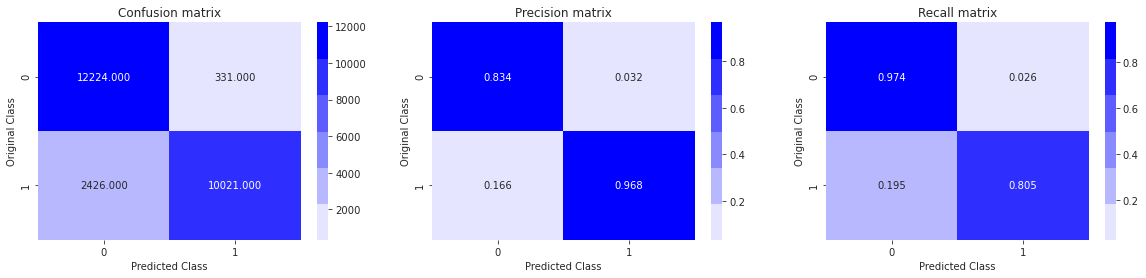

Test confusion_matrix


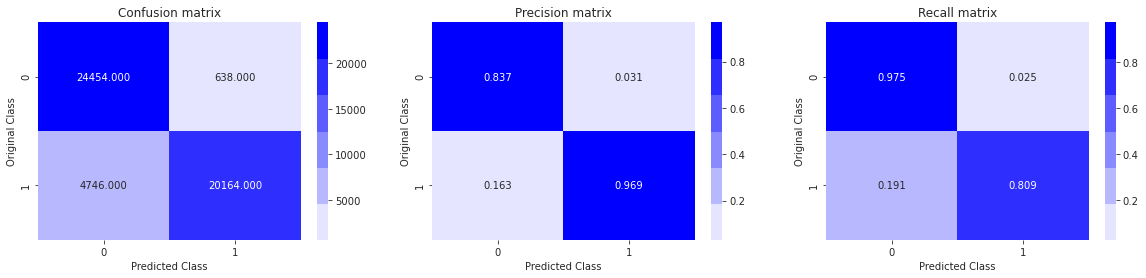

In [100]:
print('CV confusion_matrix')
plot_confusion_matrix(y_cv,y_cv_pred1)

print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred1)

<h4> Observations :- </h4>

* Confusion Matrix :- Here you'll realise that your accuracy for Test Data = (24454+20164)/50000 => 89.23%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 83.7% of them actually belong to class 0 and 16.3% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 96.9% actually belong to class 1 and 3.1% of them belong to class 0. {The Diagonal values here are the Precision values for Class 0 and Class 1}
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 your random model predicted 97.5% of them belonging to class 0 and 2.5% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 80.9% of those points have been predicted by the random model to belong to class 1 and 19.1% to belong to class 0. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 0 and the Recall values for class 1. 

### 6.1.1 Hyperparameter Tuning for Number of Estimators (Simple CV) :-

Estimators =  10 Train Score 0.8928388666673629 CV Score 0.8496074263653319
Estimators =  50 Train Score 0.8952083816430213 CV Score 0.8516524403589406
Estimators =  100 Train Score 0.8962514399247541 CV Score 0.8710569527266442
Estimators =  250 Train Score 0.8957713803648633 CV Score 0.8535656437420653
Estimators =  450 Train Score 0.8959762303631823 CV Score 0.8486951937439592


Text(0.5, 1.0, 'Estimators vs Score at depth of 5')

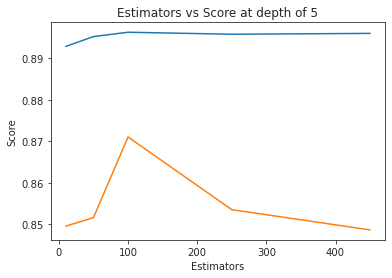

In [101]:
estimators = [10,50,100,250,450]
train_scores = []
cv_scores = []

for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    cv_sc = f1_score(y_cv,clf.predict(df_final_cv))
    cv_scores.append(cv_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'CV Score',cv_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,cv_scores,label='CV Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs Score at depth of 5')

<h4> Observations </h4>

* In order to choose the best value of our hyperparameter, the difference between Train and CV scores must be minimum.
* Therefore according to the values in our list, 100 would be a good value for the number of estimators.

### 6.1.2 Hyperparameter Tuning for Max Depth (Simple CV) :-

depth =  3 Train Score 0.8483639776460049 CV Score 0.8128562658949399
depth =  9 Train Score 0.9518630661805598 CV Score 0.8798273812144963
depth =  11 Train Score 0.9561227945930967 CV Score 0.8777448857862413
depth =  15 Train Score 0.9575120815078543 CV Score 0.882896357557628
depth =  20 Train Score 0.9578509517857509 CV Score 0.8838760642499781
depth =  35 Train Score 0.9583286394592657 CV Score 0.8798237885462555
depth =  50 Train Score 0.9583286394592657 CV Score 0.8798237885462555
depth =  70 Train Score 0.9583286394592657 CV Score 0.8798237885462555
depth =  130 Train Score 0.9583286394592657 CV Score 0.8798237885462555


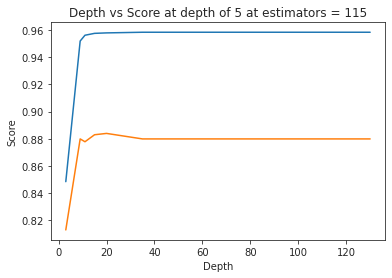

In [102]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
cv_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    cv_sc = f1_score(y_cv,clf.predict(df_final_cv))
    cv_scores.append(cv_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'CV Score',cv_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,cv_scores,label='CV Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs Score at depth of 5 at estimators = 115')
plt.show()

<h4> Observations </h4>

* Again, in order to choose the best value of our hyperparameter, the difference between Train and CV scores must be minimum.
* Therefore a value = 20 (according to the values that we chose for our list) should be good to go.

### 6.1.3 Tuning all of our Hyperparameters (Random Search CV) :-

In [103]:
start = datetime.now()

param_dist = {"n_estimators":sp_randint(80,125),
              "max_depth": sp_randint(3,30),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=30,cv=5,scoring='f1',random_state=25,return_train_score=True)
rf_random.fit(df_final_train,y_train)

print('\n Best hyperparameters:')
print(rf_random.best_estimator_)

print(" "*100)

#Best cross validation f1-score obtained from hyperparameter tuning
print("Best f1-score obtained on Cross Validation data using hyperparameter tuning: ",rf_random.best_score_)

print(" "*100)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)


 Best hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=112,
                       min_weight_fraction_leaf=0.0, n_estimators=124,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)
                                                                                                    
Best f1-score obtained on Cross Validation data using hyperparameter tuning:  0.9602486892109875
                                                                                                    
mean test scores [0.93120366 0.95669126 0.95464879 0.95288972 0.96002925 0.95821892
 0.95628389 0.8515273  0.88917374 0.93134595 0.95

### 6.1.4 Training with Best Values of Hyperparameters and obtaining CV & Test Metrics :-

In [104]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=112,
                       min_weight_fraction_leaf=0.0, n_estimators=124,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_cv_pred = clf.predict(df_final_cv)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score = ',f1_score(y_train,y_train_pred))
print('CV f1 score = ',f1_score(y_cv,y_cv_pred))
print('Test f1 score = ',f1_score(y_test,y_test_pred))

Train f1 score =  0.9614810574308438
CV f1 score =  0.8826220853497581
Test f1 score =  0.8836984889356757


CV confusion_matrix


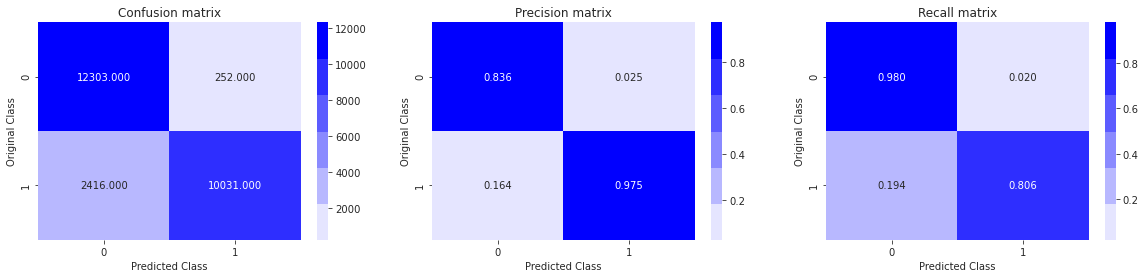

Test confusion_matrix


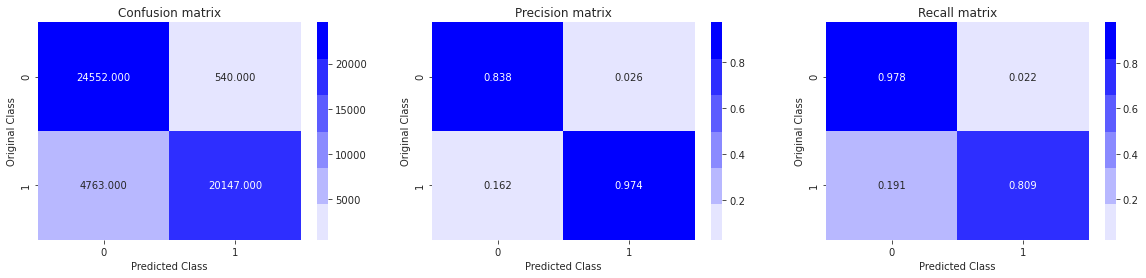

In [105]:
print('CV confusion_matrix')
plot_confusion_matrix(y_cv,y_cv_pred)

print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

<h4> Observations :- </h4>

* Confusion Matrix :- Here you'll realise that your accuracy for Test Data = (24552+20147)/50000 => 89.39%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 83.8% of them actually belong to class 0 and 16.2% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 97.4% actually belong to class 1 and 2.6% of them belong to class 0. {The Diagonal values here are the Precision values for Class 0 and Class 1}
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 your random model predicted 97.8% of them belonging to class 0 and 2.2% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 80.9% of those points have been predicted by the random model to belong to class 1 and 19.1% to belong to class 0. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 0 and the Recall values for class 1. 

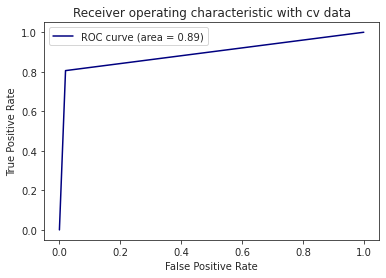

In [106]:
#Obtaining AUC Values on our CV Dataset

from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_cv,y_cv_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with cv data')
plt.legend()
plt.show()

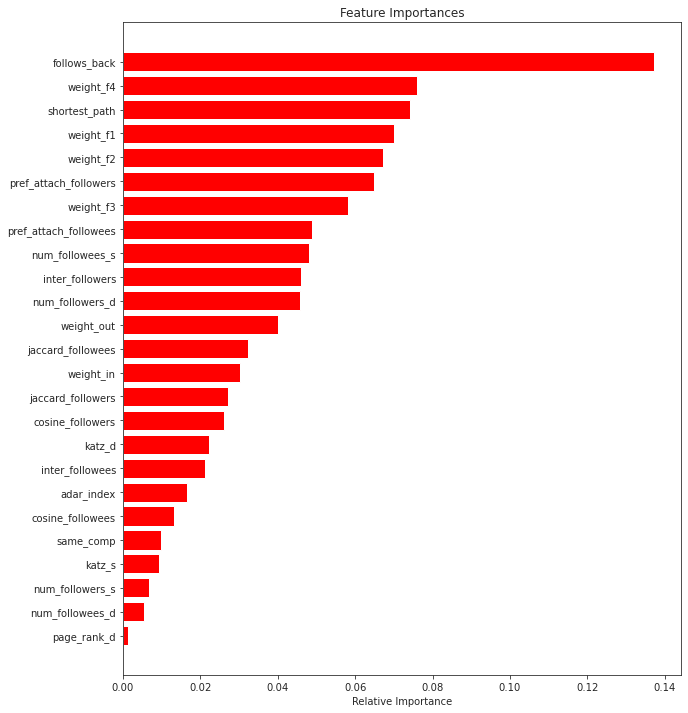

In [107]:
#Feature Importances for our Features

features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 6.2 XGBoost Classifier :-

### 6.2.1 Without Hyperparameter Tuning :-

In [108]:
start = datetime.now()
import xgboost as xgb

xgb1 = xgb.XGBClassifier(objective='binary:logistic',eval_metric = 'error',silent=False, verbose=10, n_jobs=-1)
xgb1.fit(df_final_train,y_train)

predict_y_train1 = xgb1.predict(df_final_train)
predict_y_cv1 = xgb1.predict(df_final_cv)
predict_y_test1 = xgb1.predict(df_final_test)

print("The Train f1-score is:", f1_score(y_train, predict_y_train1))
print("The CV f1-score is:", f1_score(y_cv, predict_y_cv1))
print("The Test f1-score is:", f1_score(y_test, predict_y_test1))
print(" "*100)

print("Time taken to run this cell :", datetime.now() - start)

The Train f1-score is: 0.9953889273982098
The CV f1-score is: 0.8648770178515222
The Test f1-score is: 0.8668894520824455
                                                                                                    
Time taken to run this cell : 0:01:05.199478


CV confusion matrix


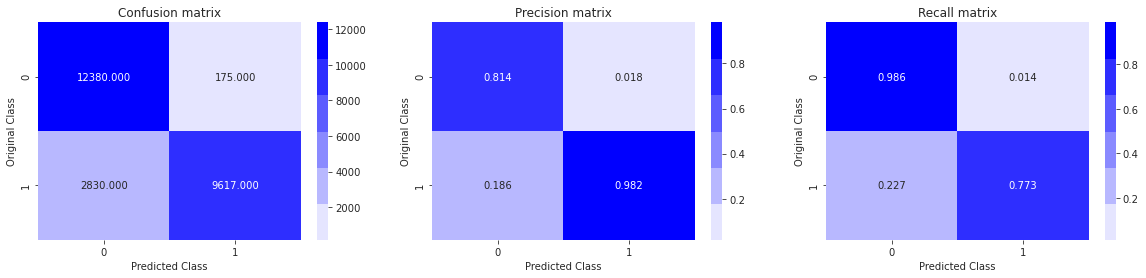

Test confusion matrix


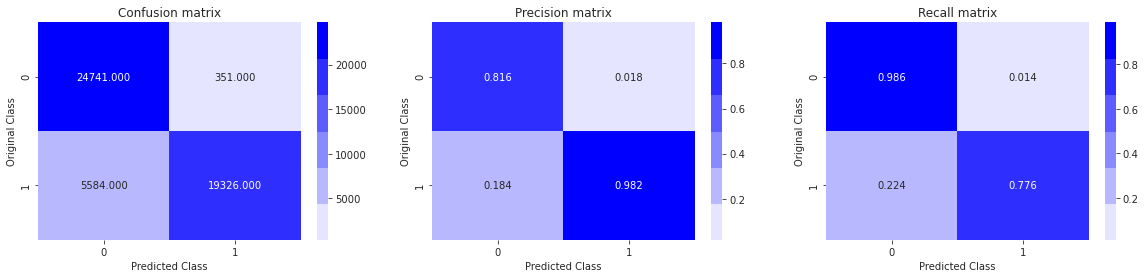

In [109]:
print('CV confusion matrix')
plot_confusion_matrix(y_cv,predict_y_cv1)

print('Test confusion matrix')
plot_confusion_matrix(y_test,predict_y_test1)

<h4> Observations :- </h4>

* Confusion Matrix :- Here you'll realise that your accuracy for Test Data = (24741+19326)/50000 => 88.13%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 81.6% of them actually belong to class 0 and 18.4% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 98.2% actually belong to class 1 and 1.8% of them belong to class 0. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 your random model predicted 98.6% of them belonging to class 0 and 1.4% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 77.6% of those points have been predicted by the random model to belong to class 1 and 22.4% to belong to class 0. 

### 6.2.2 Tuning all of our Hyperparameters (Random Search CV) :-

In [110]:
#Following blog was used as a reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

import xgboost as xgb

start = datetime.now()

#A parameter grid for XGBoost
params = {
        'eta' : [0.05,0.1,0.3,0.5],
        'min_child_weight': [3,4,5,6,7,8,9,10,11,12],
        'gamma': [0,0.10,0.20,0.50,0.75],
        'subsample': [0.45,0.5,0.6,0.7,0.8,0.9] ,
        'colsample_bytree': [0.45,0.5,0.6,0.7,0.8,0.9],
        'max_depth': [3,4,5,6,7,8,9,10,11,12],
        'n_estimators' : [100,150,250,300,500,750,1000,3000]
        }

xgb = xgb.XGBClassifier(objective='binary:logistic', silent=False, verbose=10, n_jobs=-1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, scoring='f1',
                                   n_jobs=-1, cv=5, verbose=10, random_state=0)
random_search.fit(df_final_train,y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)

print(" "*100)

#Best cross validation log loss obtained from hyperparameter tuning
print("Best f1-score obtained on Cross Validation data using hyperparameter tuning: ",random_search.best_score_)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed: 35.0min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed: 36.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 51.8min finished



 Best hyperparameters:
{'subsample': 0.5, 'n_estimators': 750, 'min_child_weight': 3, 'max_depth': 5, 'gamma': 0.2, 'eta': 0.1, 'colsample_bytree': 0.9}
                                                                                                    
Best f1-score obtained on Cross Validation data using hyperparameter tuning:  0.9847703417181991
Time taken to run this cell : 0:57:05.907604


### 6.2.3 Training with Best Values of Hyperparameters and obtaining CV & Test Metrics :-

In [112]:
start = datetime.now()
import xgboost as xgb

xgb2 = xgb.XGBClassifier(objective='binary:logistic',eval_metric = 'error', eta = 0.1, max_depth=5,
                        subsample = 0.5,gamma = 0.2, colsample_bytree = 0.9, min_child_weight=3,
                        n_estimators = 750,silent=False, verbose=10, n_jobs=-1)
xgb2.fit(df_final_train,y_train)

predict_y_train2 = xgb2.predict(df_final_train)
predict_y_cv2 = xgb2.predict(df_final_cv)
predict_y_test2 = xgb2.predict(df_final_test)

print("The Train f1-score is:", f1_score(y_train, predict_y_train2))
print("The CV f1-score is:", f1_score(y_cv, predict_y_cv2))
print("The Test f1-score is:", f1_score(y_test, predict_y_test2))
print(" "*100)

print("Time taken to run this cell :", datetime.now() - start)

The Train f1-score is: 0.9996587784267678
The CV f1-score is: 0.8349335302806499
The Test f1-score is: 0.8370765832106039
                                                                                                    
Time taken to run this cell : 0:05:28.226680


CV confusion matrix


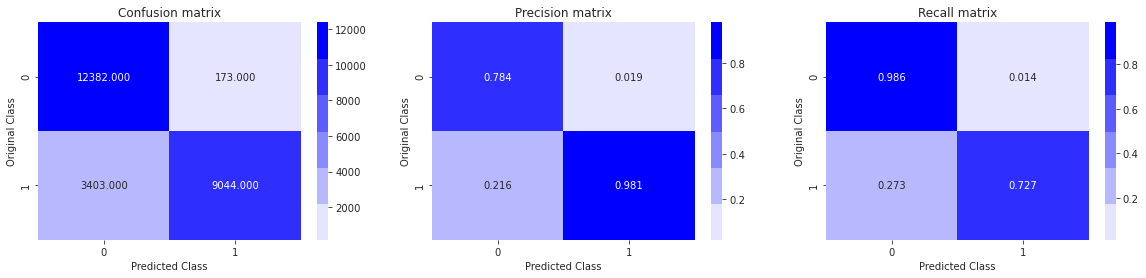

Test confusion matrix


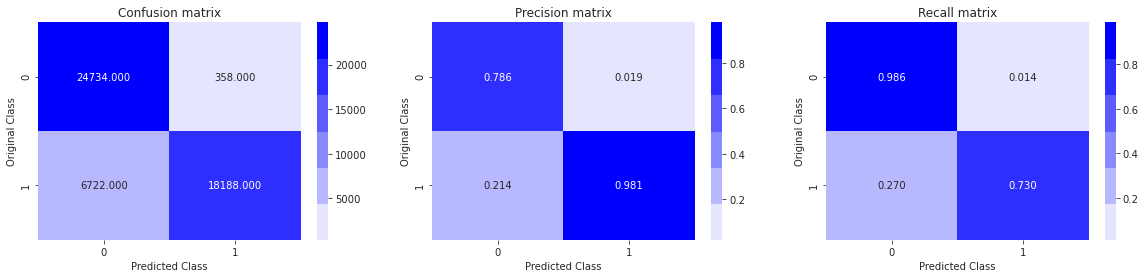

In [113]:
print('CV confusion matrix')
plot_confusion_matrix(y_cv,predict_y_cv2)

print('Test confusion matrix')
plot_confusion_matrix(y_test,predict_y_test2)

<h4> Observations :- </h4>

* Confusion Matrix :- Here you'll realise that your accuracy for Test Data = (24734+18188)/50000 => 85.84%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 78.6% of them actually belong to class 0 and 21.4% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 98.1% actually belong to class 1 and 1.9% of them belong to class 0. 
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 your random model predicted 98.6% of them belonging to class 0 and 1.4% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 73.0% of those points have been predicted by the random model to belong to class 1 and 27.0% to belong to class 0. 

# 7. Conclusion :-

This has been a Link Prediction Problem that was posted by Facebook :- However, unlike the social media platforms such as Facebook/Linkedin which have undirected edges, this social media data provided is in the form of pairs of source and destination vertices, which makes us to believe that this real world dataset could be from Instagram which is owned by Facebook :- Our Data has Directed Graphs. 

The Business requirement suggested that there were no strict latency constraints, and we could store the link prediction results for a particular user in a data structure such as a hash table, and show these top recommendations to the user once he/she logs in to the platform. Also, in our real world engineering challenge we would have had data snapshots available across various time stamps such that we can use the oldest data for Training and the upcoming timestamps in order to validate whether our link prediction (recommendations) worked as expected or not. However, for our case scenario, the problem is that we have been provided with a single time snapshot and therefore all we can carry out is Random Split of our data.

In order to carry out featurizations, we take a look at a lot of ideas, most of which have been detailed in the respective sections of this IPYNB. These approaches include very simple approaches like whether the other person follows back his followers or not, Ranking ideas like PageRank which have been used in Search engine link ranking, graph based features such as Katz Centrality, Adar Index, SVD Based features, Preferential attachment etc. Finally we trained our non-linear models. The summary for the results obtained from each of these models is listed below :-

In [1]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names=["Model","Test F1-Score","Test Accuracy","Pre (Cl-0)","Pre (Cl-1)","Re (Cl-0)",
               "Re (Cl-1)"]

x.add_row(["Random Forest (W/O Tuning)","0.882","89.23%","83.70%","96.90%","97.50%","80.90%"])
x.add_row(["Random Forest (With Tuning)","0.883","89.39%","83.80%","97.40%","97.80%","80.90%"])
x.add_row(["XGBoost (W/O Tuning)","0.866","88.13%","81.60%","98.20%","98.60%","77.60%"])
x.add_row(["XGBoost (With Tuning)","0.837","85.84%","78.60%","98.10%","98.60%","73.00%"])

print(x)

+-----------------------------+---------------+---------------+------------+------------+-----------+-----------+
|            Model            | Test F1-Score | Test Accuracy | Pre (Cl-0) | Pre (Cl-1) | Re (Cl-0) | Re (Cl-1) |
+-----------------------------+---------------+---------------+------------+------------+-----------+-----------+
|  Random Forest (W/O Tuning) |     0.882     |     89.23%    |   83.70%   |   96.90%   |   97.50%  |   80.90%  |
| Random Forest (With Tuning) |     0.883     |     89.39%    |   83.80%   |   97.40%   |   97.80%  |   80.90%  |
|     XGBoost (W/O Tuning)    |     0.866     |     88.13%    |   81.60%   |   98.20%   |   98.60%  |   77.60%  |
|    XGBoost (With Tuning)    |     0.837     |     85.84%    |   78.60%   |   98.10%   |   98.60%  |   73.00%  |
+-----------------------------+---------------+---------------+------------+------------+-----------+-----------+
